In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import os
import cv2
import dlib
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

## Align images to 112x112 pixels with 5 facial landmarks

### facial landmarks 찾기 
https://a292run.tistory.com/entry/Facial-Landmarks-for-Face-Recognition-with-Dlib-1  
- dlib: 얼굴 랜드마크 탐지기  
- 68개의 랜드마크를 찾아줌. -> 우리는 5개의 landmark만 필요로 함.   

In [3]:
# !wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

# !bunzip2 /content/drive/MyDrive/metasoul/MagFace/shape_predictor_68_face_landmarks.dat.bz2

# datFile =  "/content/drive/MyDrive/metasoul/MagFace/shape_predictor_68_face_landmarks.dat"

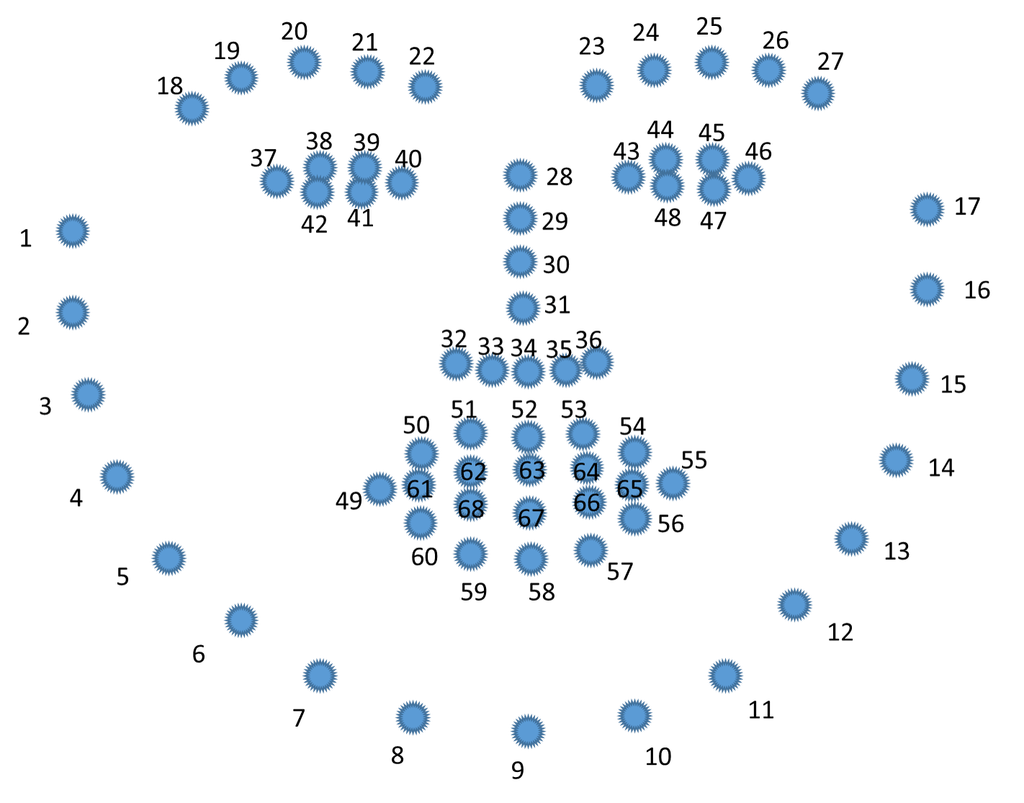

In [4]:
# 68개의 landmark
from IPython.display import Image
Image('/content/drive/MyDrive/metasoul/MagFace/image/68landmark.png', height = 300, width = 300)

# 직접 해보니까 아래 번호랑 좀 다르게 부여해야 함. -> 숫자가 0부터 시작해야 해서 1씩 빼야 함.

In [5]:
cd "/content/drive/MyDrive/metasoul/MagFace"

/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace


In [6]:
# 랜드마크 탐지기 load
face_detector = dlib.get_frontal_face_detector() # 정면 사진을 가지고 detection하겠다
landmark_detector = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") # 68개의 점을 가지고 옴.

- 5개의 점만 찾아주는 버전(shape_predictor_5_face_landmarks.dat)으로 구하면 어떻게 돌아가는지 확인하기  
    norm_crop을 적용하면 얼굴의 정면을 찾아주지 못함.

### face detection & landmark detections

In [7]:
# 이미지 별로 랜드마크와 route를 찾아줌.
def route_landmark_5_detection(img_path):
    # read_img
    img = dlib.load_rgb_image(img_path) 

    # face_detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # equalizeHist 해주기(landmark 찾기 위해서, 이미지 변환하는 것은 아님.)
    gray_equalize = cv2.equalizeHist(gray)
    faces = face_detector(gray_equalize, 1) # upscale: 한 번을 하면 큰 이미지를 인식함.

    # route & landmark detection
    route_list = []
    landmark_list = []
    RIGHT_EYE = list(range(36, 42))
    LEFT_EYE = list(range(42, 48))
    EYES = list(range(36, 48))
    ROUTES = [17, 18, 19, 24, 25, 26, 11, 5, 17]

    for k, d in enumerate(faces):  # 얼굴마다
        landmarks = landmark_detector(gray_equalize, d) 
        # route detection: 회전시켰을 때 route의 x, y를 결정할 점의 좌표
        for n in ROUTES: 
            x = landmarks.part(n).x 
            y = landmarks.part(n).y 
            route_list.append([x, y]) 

        # landmark detection
        # 오른쪽 눈
        x_right_sum = 0
        y_right_sum = 0
        for n in RIGHT_EYE:
            x_right_sum += landmarks.part(n).x 
            y_right_sum += landmarks.part(n).y 

        x_right = int(x_right_sum / 6)
        y_right = int(y_right_sum / 6)
        right_eye_center = [x_right, y_right]
        landmark_list.append(right_eye_center) 
        # cv2.circle(gray, (x_right, y_right), 2, (255, 255, 0), -1)

        # 왼쪽 눈
        x_left_sum = 0
        y_left_sum = 0
        for n in LEFT_EYE:
            x_left_sum += landmarks.part(n).x 
            y_left_sum += landmarks.part(n).y 

        x_left = int(x_left_sum / 6)
        y_left = int(y_left_sum / 6)
        left_eye_center = [x_left, y_left]
        landmark_list.append(left_eye_center) 
        # cv2.circle(gray, (x_left, y_left), 2, (255, 255, 0), -1)

        # 코: 33, 입: 48, 54
        for n in [33, 48, 54]: 
            x = landmarks.part(n).x 
            y = landmarks.part(n).y 
            landmark_list.append([x, y]) 
            # cv2.circle(gray, (x, y), 2, (255, 255, 0), -1)

    # route 그리기
    # for i in range(0, len(route_list)-1): 
    #     from_coordinate = tuple(route_list[i])
    #     to_coordinate = tuple(route_list[i+1]) 
    #     gray = cv2.line(gray, from_coordinate, to_coordinate, (255, 255, 0), 1)

    route_array = np.array(route_list)
    landmark_array = np.array(landmark_list)
    return route_array, landmark_array, gray

### Align images to 112x112 pixels
face_align.py  
https://github.com/deepinsight/insightface/blob/cdc3d4ed5de14712378f3d5a14249661e54a03ec/python-package/insightface/utils/face_align.py  
- face_align.py를 그대로 사용하면 얼굴 외 공간이 너무 많이 포함되고, 헤어스타일이나 얼굴형이 제외되지 않음.  
- 이미지 눈썹, 눈, 코, 입만 남기고 zero_padding을 하기 위해 face_align.py를 수정한 face_align_modified.py를 사용함. 

In [8]:
sys.path.append("/content/drive/MyDrive/metasoul/MagFace")
import face_align_modified

In [9]:
# norm_crop: 얼굴 돌리고 얼굴 부분(눈썹, 눈, 코, 입)만 자름 & normalize & zero padding
def face_alignment(img_path):
    img_route_array, img_landmark_array, img_gray = route_landmark_5_detection(img_path)
    out_normalize, out_equalize = face_align_modified.norm_crop(img_gray, img_route_array, img_landmark_array)
    return out_normalize, out_equalize

### 이미지 전처리



In [10]:
info = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/info.csv')
info.rename(columns={'Unnamed: 0':'filename', '0':'id'}, inplace = True)
info['path'] += '.jpg'
info.head()

,filename,id,path
0,0,0,19062421/S001/L1/E01/C5.jpg
1,1,0,19062421/S001/L1/E01/C6.jpg
2,2,0,19062421/S001/L1/E01/C7.jpg
3,3,0,19062421/S001/L1/E01/C8.jpg
4,4,0,19062421/S001/L1/E01/C9.jpg


In [11]:
cd '/content/drive/MyDrive/metasoul/face_data' 

/content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/face_data


In [12]:
# 19062421 사진을 보고 equalizeHist 적용할지 말지 고민해보기
# 빛의 밝기가 다른 사진들에 대해서 equalizeHist를 적용할지 말지 결정하려는 것이니까 빛의 밝기에 따라 30장의 이미지만 보기
id0_30 = info[info['id'] == 0][0:300:10]
len(info[info['id'] == 0][0:300:10])

30

normalize:


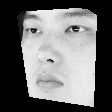

equalize:


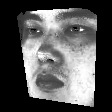

0
normalize:


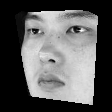

equalize:


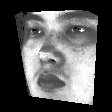

1
normalize:


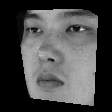

equalize:


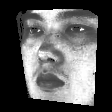

2
normalize:


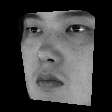

equalize:


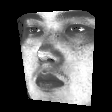

3
normalize:


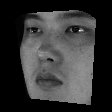

equalize:


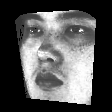

4
normalize:


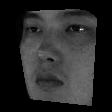

equalize:


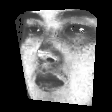

5
normalize:


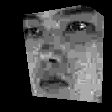

equalize:


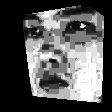

6
normalize:


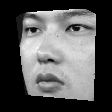

equalize:


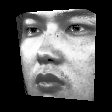

7
normalize:


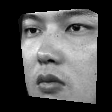

equalize:


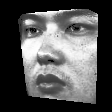

8
normalize:


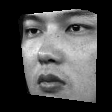

equalize:


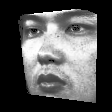

9
normalize:


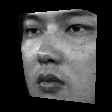

equalize:


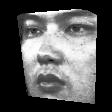

10
11
normalize:


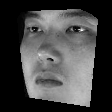

equalize:


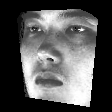

12
normalize:


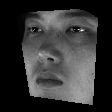

equalize:


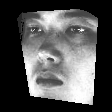

13
14
normalize:


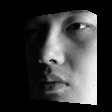

equalize:


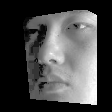

15
normalize:


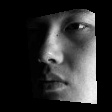

equalize:


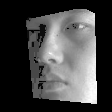

16
normalize:


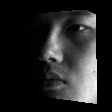

equalize:


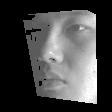

17
normalize:


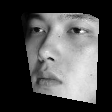

equalize:


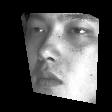

18
normalize:


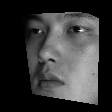

equalize:


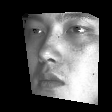

19
normalize:


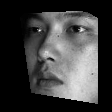

equalize:


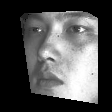

20
normalize:


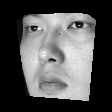

equalize:


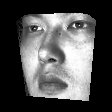

21
normalize:


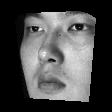

equalize:


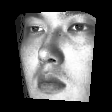

22
normalize:


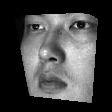

equalize:


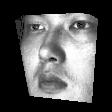

23
24
normalize:


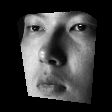

equalize:


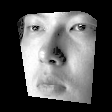

25
26
27
28
29
e: 7


In [13]:
id0_lst = list(id0_30['path'])
id0_train_lst = []
e = 0
for i, path in enumerate(id0_lst):
    try:
        aligned_normalize, aligned_equalize = face_alignment(path)
        print('normalize:')
        cv2_imshow(aligned_normalize)
        print('equalize:')
        cv2_imshow(aligned_equalize)
    except: 
        e += 1
    print(i)
print('e:', e)

In [14]:
# 6등분 나누는 코드도 짜려고 했는데 equalize vs normalize 생각보다 오래 고민해서 코드는 아직 짜지 못함.
# 어떤 경로와 이름으로 사진 저장할지 의논한 후에 코드 짜면 좋을 듯함.